## Introduction

This notebook describes the analysis of extracellular recording data provided alongside Duskiewicz et. al, 2024. These data consists of recordings made with 64-channel electrodes from the antero-dorsal nucleus (ADN) and pre- and post-subicular regions of mice ( _Mus musculus_ ). These regions are endowed with neurons that code for head direction cells. The analysis in this notebook will focus on the properties of these cells as wells as interaction between the firing rates of two major types of neurons, excitatory and inhibitory neurons (a classification based mostly on their waveforms and firing rates). 

In [474]:
import pynapple as nap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import os
from os.path import dirname, join as pjoin
import scipy.io as sio

import pymatreader

import pandas as pd

import random
import matplotlib as mpl

import ipywidgets as widgets


from sklearn import linear_model

import copy


from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

import seaborn as sns

import shap

import scipy.stats as stats

## Loading all the relevant data

In [556]:
data_dir = pjoin('C:\\Users\\Acer\\Documents\\compNeuroProjects\\neural_reco_offline\\Duszkiewicz2024', 'Dataset_2', 'A3705-200306', 'Data')
spikeData_fname = pjoin(data_dir, 'SpikeData.mat')
ahv_fname = pjoin(data_dir, 'Ahv.mat')
behav_epochs_fname = pjoin(data_dir, 'BehavEpochs.mat')
angle_fname = pjoin(data_dir, 'Angle.mat')
epoch_ts_fname = pjoin(data_dir, 'Epoch_TS.csv')
tracking_fname = pjoin(data_dir, "Tracking_data.csv")
CellTypes_fname = pjoin(data_dir, "CellTypes.mat")
waveformFeatures_fname = pjoin(data_dir, "WaveformFeatures.mat")
waveforms_fname = pjoin(data_dir, "Waveforms.mat")



In [465]:
os.listdir(data_dir)

['._Ahv.mat',
 '._Angle.mat',
 '._BehavEpochs.mat',
 '._BrainArea.mat',
 '._CellDepth.mat',
 '._CellTypes.mat',
 '._Epoch_TS.csv',
 '._Position.mat',
 '._SpikeData.mat',
 '._Tracking_data.csv',
 '._Velocity.mat',
 '._WaveformFeatures.mat',
 '._Waveforms.mat',
 'Ahv.mat',
 'Angle.mat',
 'BehavEpochs.mat',
 'BrainArea.mat',
 'CellDepth.mat',
 'CellTypes.mat',
 'Epoch_TS.csv',
 'Position.mat',
 'SpikeData.mat',
 'Tracking_data.csv',
 'Velocity.mat',
 'WaveformFeatures.mat',
 'Waveforms.mat']

In [557]:
spikeData = pymatreader.read_mat(spikeData_fname)
ahv = pymatreader.read_mat(ahv_fname)
behav_epochs = pymatreader.read_mat(behav_epochs_fname)
angleData = pymatreader.read_mat(angle_fname)
CellTypesData = pymatreader.read_mat(CellTypes_fname)
waveform_features = pymatreader.read_mat(waveformFeatures_fname)
waveforms = pymatreader.read_mat(waveforms_fname)


print(behav_epochs.keys())
print(spikeData.keys())
print(angleData.keys())



dict_keys(['__header__', '__version__', '__globals__', 'sleep1Ep', 'sleep1Ep_Info', 'wake1Ep', 'wake1Ep_Info', 'sleep2Ep', 'sleep2Ep_Info', 'wake2Ep', 'wake2Ep_Info'])
dict_keys(['__header__', '__version__', '__globals__', 'S', 'S_Info', 'shank', 'shank_Info', 'cellIx', 'cellIx_Info'])
dict_keys(['__header__', '__version__', '__globals__', 'ang', 'ang_Info'])


In [21]:
sum(CellTypesData['fs'])

np.uint8(25)

In [39]:
tracking_data = pd.read_csv(tracking_fname)
epoch_ts = pd.read_csv(epoch_ts_fname)

In [41]:
time_hd = angleData['ang']['t']
ang_rad = angleData['ang']['data']
ahv_data = ahv['ahv']['data']
x_circ = np.cos(ang_rad)[1000:2000]
y_circ = np.sin(ang_rad)[1000:2000]
amp_circ = time_hd[1000:2000]
# plt.scatter(amp_circ*x_circ, amp_circ*y_circ, s = 5, c='k', marker='.', alpha=0.8)
# # plt.plot(time_hd, np.sin(hd))
# # plt.plot(time_hd, hd)
# ax = plt.gca()


In [25]:
ahv['ahv']['t']

array([ 5034.104,  5034.114,  5034.124, ..., 16195.94 , 16195.95 ,
       16195.96 ])

The function below will be used by the widgets to create a small animation to provide a sense of the range of head directions the animal undertook during this particular session

In [27]:
def plot_chunk(iter_):

    global time_hd, angleData, chunk_period, slide_period, n_chunks, time_dt, time_hd, rad, plot_time_window, slide_window



    fig, ax = plt.subplots()
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    chunk_period = 1
    slide_period = 0.25
    n_chunks = (time_hd.max() - time_hd.min())/chunk_period 
    time_dt = time_hd[1]-time_hd[0]

    time_hd = angleData['ang']['t']
    rad = angleData['ang']['data']


    plot_time_window = chunk_period/time_dt
    slide_window = (slide_period/time_dt)

    # iter_ = 0
    t_start = int(iter_*slide_window)
    t_end = t_start + int(plot_time_window)
        
    x_circ = np.cos(rad)[t_start:t_end]
    y_circ = np.sin(rad)[t_start:t_end]

    x_circ_end = x_circ[-1]
    y_circ_end = y_circ[-1]
        
    scattr1 = plt.scatter(x_circ, y_circ, s = 5, c='k', marker='.', alpha=0.8)
    scattr2 = plt.scatter(x_circ_end, y_circ_end, s = 25, c='r', marker='o', alpha=0.8)
    line = plt.plot([0,x_circ_end], [0,y_circ_end], linewidth=2, color='r')


In [467]:
widgets.interact(plot_chunk, iter_=widgets.Play(min=0, max=90));

interactive(children=(Play(value=0, description='iter_', max=90), Output()), _dom_classes=('widget-interact',)…

This particular session is composed of two sleep epochs interleaved by two waking episodes. The animals were exploring a square-shaped open field during those 'wake' episodes.

In [589]:
behav_epochs

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Tue Jun  1 15:32:21 2021',
 '__version__': '1.0',
 '__globals__': [],
 'sleep1Ep': {'units': {'quantity': 'time', 'unit': 'ts', 'value': 1},
  'start': 5e-05,
  'stop': 5030.424},
 'sleep1Ep_Info': 'No info',
 'wake1Ep': {'units': {'quantity': 'time', 'unit': 'ts', 'value': 1},
  'start': 5030.424,
  'stop': 7669.116},
 'wake1Ep_Info': 'No info',
 'sleep2Ep': {'units': {'quantity': 'time', 'unit': 'ts', 'value': 1},
  'start': 7669.116,
  'stop': 13710.71},
 'sleep2Ep_Info': 'No info',
 'wake2Ep': {'units': {'quantity': 'time', 'unit': 'ts', 'value': 1},
  'start': 13710.71,
  'stop': 16198.56},
 'wake2Ep_Info': 'No info'}

## Preprocessing with Pynapple

We will define the start and end times of the waking and sleeping epochs in the formats of 'pynapple' package . Later these 'IntevalSet' can be used to analyze the data exclusively in either the 'wake_epochs' or 'sleep_epochs'.

In [42]:
wake_epochs = nap.IntervalSet(start=[behav_epochs['wake1Ep']['start'], behav_epochs['wake2Ep']['start']], end=[behav_epochs['wake1Ep']['stop'], behav_epochs['wake2Ep']['stop']])
sleep_epochs = nap.IntervalSet(start=[behav_epochs['sleep1Ep']['start'], behav_epochs['sleep2Ep']['start']], end=[behav_epochs['sleep1Ep']['stop'], behav_epochs['sleep2Ep']['stop']])
print(wake_epochs)
print(sleep_epochs)


  index     start       end
      0   5030.42   7669.12
      1  13710.7   16198.6
shape: (2, 2), time unit: sec.
  index     start       end
      0     5e-05   5030.42
      1  7669.12   13710.7
shape: (2, 2), time unit: sec.


In the blocks of codes below we are extracting the IDs of cells recorded in the current sessions. These IDs will be used to gain information from across the files.

In [43]:
spikeData.keys()

dict_keys(['__header__', '__version__', '__globals__', 'S', 'S_Info', 'shank', 'shank_Info', 'cellIx', 'cellIx_Info'])

In [44]:
sp_times = spikeData["S"]['C']
cell_ids = spikeData["cellIx"]
len(sp_times) == len(cell_ids)

True

In [45]:
l_cellids = []
for i in range(len(cell_ids)):
    if (type(sp_times[i]['tsd']['t']) == type(np.arange(10))) and (len(sp_times[i]['tsd']['t']) > 1000):
        l_cellids.append(cell_ids[i])
        # len(sp_times[i]['tsd']['t'])
# l_cellids

Spike times are stored in 'TsGroup' (group of time series) data structure. We will also store the head direction and angular velocity in 'Tsd' (time series dataframes). Note that we have constrained the times to 'wake_epochs' while storing the head direction data.  

In [64]:
spData = {

    cell_id:nap.Ts(t=sp_times[cell_ind]['tsd']['t']) for cell_ind,cell_id in enumerate(l_cellids)

}

# sp_times_counter = nap.TsGroup(spData, time_support=counter_epochs)

sp_times_wake = nap.TsGroup(spData, time_support=wake_epochs)


head_direction = nap.Tsd(

    t = angleData['ang']['t'],
    d = angleData['ang']['data'],
    time_support=wake_epochs
    )

angular_velocity = nap.Tsd(

    t = ahv['ahv']['t'],
    d = ahv['ahv']['data']
    )

# count1 = sp_times_wake.count(bin_size=1.0, time_units='s')
# print(count1) 

## Estimating tuning curves

We will compute the head direction tuning curves of the neurons/units from the 'wake_epochs' of this session. We will plot 64 of the tuning curves calculated in a 8 by 8 grid of subplots.

In [47]:
tuning_curve_wake = nap.compute_1d_tuning_curves(

    group = sp_times_wake,
    feature=head_direction,
    nb_bins=120,
    minmax=(-np.pi, np.pi)
)

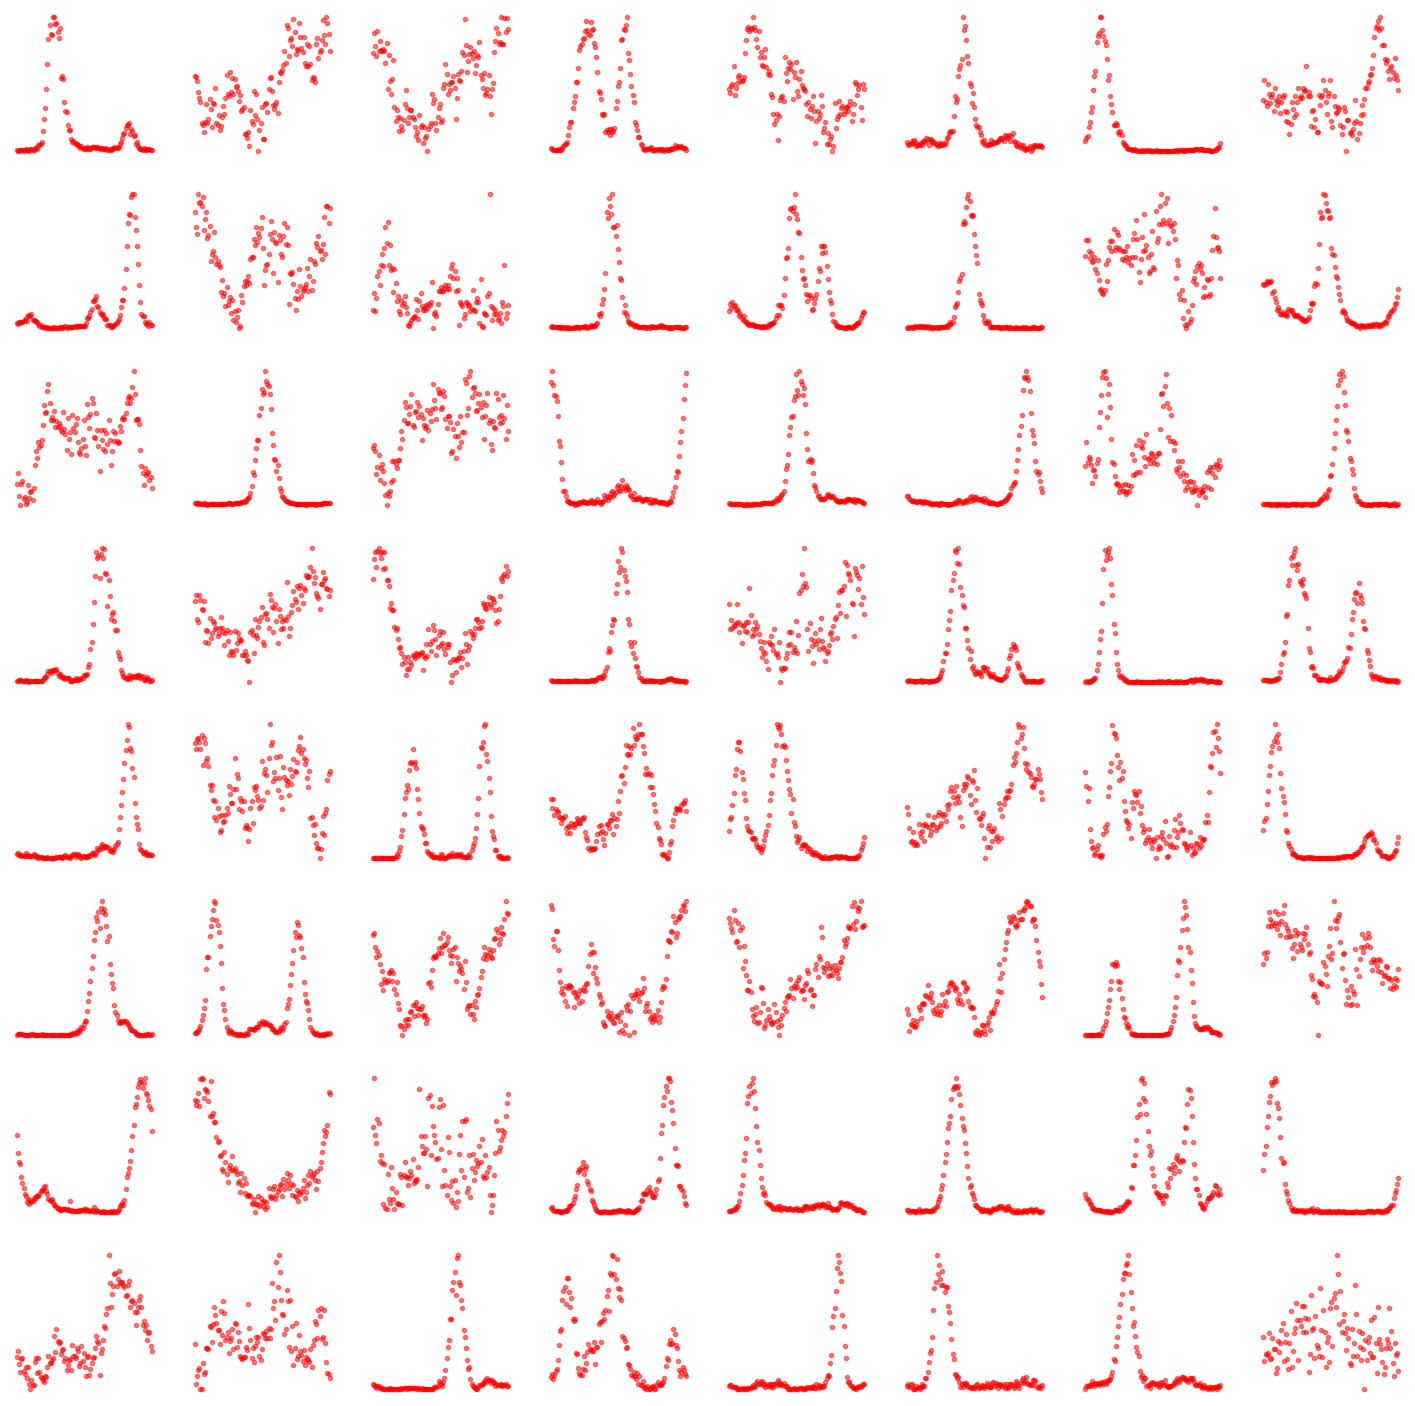

In [48]:
fig, axes = plt.subplots(8,8, figsize=(18,18), subplot_kw={'facecolor':'#ebf5ff'})

in_tune = 0
for i_ax in range(8):
    for j_ax in range(8):
        
        axes[i_ax, j_ax].scatter(tuning_curve_wake[l_cellids[in_tune]].axes[0].tolist(), tuning_curve_wake[l_cellids[in_tune]].tolist(), c='r', marker='.', plotnonfinite=True, alpha=0.5)
        # axes[i_ax, j_ax].scatter(tuning_curve_sleep[in_tune].axes[0].tolist(), tuning_curve_sleep[in_tune].tolist(), c='k', marker='.', plotnonfinite=True, alpha=0.5)
        axes[i_ax, j_ax].set_axis_off()
        in_tune += 1


In [67]:
sp_times_wake.getby_threshold("rate", 1.0)

Index    rate
-------  --------
2        2.36417
3        12.23632
4        17.88808
5        5.42764
6        11.60002
7        1.61844
8        6.30483
...      ...
111      31.86807
112      6.41583
113      2.74376
115      4.26974
116      6.89217
117      2.4063
118      6.72461

In [72]:
# # plt.figure(figsize = (34,34))
# fig = doc_plots.plot_head_direction_tuning(
#     tuning_curve_wake, sp_times_wake, head_direction, threshold_hz=0, start=6000, end=6010, figsize=(34,34)
# )

## Analysis

Below, we will examine each neuron (or unit) identified in this session and extract their firing rate, calculated from spike times binned every 0.5 seconds (bin_size). We will perform this separately for sleep and wake episodes. Once we have firing rates of all neurons, we will use each neuron's firing rate as a response variable and the firing rates of all other neurons as predictors in a randomforest classifier model.

Random forest classifier builds a large number of decision trees on subsets of the data and aggregates their output to improve prediction accuracy. We will use permutation feature importance to estimate the significance of each feature/predictor, which in this case is the firing rate of that neuron. We will then sort the importance values and select ten most important predictors (neurons) for each neuron, as determined by the permutation importance method.

Armed with this data, we can ask how many of the top ten important neurons are excitatory and how many are inhibitory. As we will see in the following section, the answer to this question depends on which neuron is used as the response variable. 

In [ ]:
wake_ep1 = nap.IntervalSet(start=[behav_epochs['wake1Ep']['start']], end=[behav_epochs['wake1Ep']['stop']])

bin_size = 0.5
count_ep1 = sp_times_wake.count(bin_size, ep=wake_ep1)

In [405]:
sp_times_slp = nap.TsGroup(spData, time_support=sleep_epochs)
sleep_ep1 = nap.IntervalSet(start=[behav_epochs['sleep1Ep']['start']], end=[behav_epochs['sleep1Ep']['stop']])
bin_size = 0.5
count_ep2 = sp_times_slp.count(bin_size, ep=sleep_ep1)

In [ ]:

def find_predictorNeurons_for_each_neuron(count_ep1):

    col_names = count_ep1.columns
    #len(col_names)
    col_indices = np.arange(len(col_names), dtype=np.int32).tolist()

    l_imp_neurons = []

    for ind_neuron in col_indices: 

        col_indices_copy = copy.deepcopy(col_indices)

        ele_popped = col_indices_copy.pop(ind_neuron)
        every_othr_ele = col_indices_copy

        if (not CellTypesData['fs'][ele_popped]) and (not CellTypesData['ex'][ele_popped]):
            continue

        # print("element popped: ", ele_popped)
        # print("other neurons indices: ", every_othr_ele)
        # print("other neurons: ", col_names[every_othr_ele])

        # plt.plot(count_ep1[:,ele_popped])
        # ax = plt.gca()
        # st_t = wake_ep1['start'][0]
        # end_t = st_t + 100
        # ax.set_xlim([st_t, end_t])

        # print("Firing rate of predictor neurons : ", count_ep1[:, every_othr_ele])

        X = count_ep1[:, every_othr_ele].as_array()
        # X = np.array(X)
        y = count_ep1[:, ele_popped]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

        clf = RandomForestClassifier(n_estimators=100, random_state=42)

        clf.fit(X_train, y_train)

        # count_ep1[:, every_othr_ele].as_array()
        feature_names = every_othr_ele
        importances = clf.feature_importances_

        # Permutation feature importance
        
        result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
        perm_imp_df = pd.DataFrame({'Feature': feature_names, 'Permutation Importance': result.importances_mean}).sort_values('Permutation Importance', ascending=False)


        
        arr = perm_imp_df['Permutation Importance']
        sorted_indices = sorted(range(len(arr)), key=lambda k: arr[k], reverse=True)
        indices_imp_neurons = perm_imp_df['Feature'][sorted_indices][:10]

        important_neurons = {'neuron_index': ele_popped, 'indices_imp_neurons':indices_imp_neurons.values, 
                     'num_fs': sum(CellTypesData['fs'][indices_imp_neurons.values]), 
                     'num_ex': sum(CellTypesData['ex'][indices_imp_neurons.values]), 
                     'is_fs':CellTypesData['fs'][ele_popped],
                     'is_ex':CellTypesData['ex'][ele_popped]
                     }
        l_imp_neurons.append(important_neurons)
        
    return l_imp_neurons

        

In [ ]:
l_imp_neurons = find_predictorNeurons_for_each_neuron(count_ep1)


In [ ]:
l_imp_neurons_slp = find_predictorNeurons_for_each_neuron(count_ep2)

In [ ]:
l_imp_neurons_slp

In [413]:
l_inh_frac_fs = []
l_inh_frac_ex = []

for neuron in l_imp_neurons:
    num_fs = neuron['num_fs']
    num_ex = neuron['num_ex']
    if neuron['is_fs']:
        l_inh_frac_fs.append(num_fs/(num_fs + num_ex))
    elif neuron['is_ex']:
        l_inh_frac_ex.append(num_fs/(num_fs + num_ex))

In [414]:
l_inh_frac_fs_slp = []
l_inh_frac_ex_slp = []

for neuron in l_imp_neurons_slp:
    num_fs = neuron['num_fs']
    num_ex = neuron['num_ex']
    if neuron['is_fs']:
        l_inh_frac_fs_slp.append(num_fs/(num_fs + num_ex))
    elif neuron['is_ex']:
        l_inh_frac_ex_slp.append(num_fs/(num_fs + num_ex))

In [469]:
l_neuron_type = []
l_inh_inf_frac = []
# l_exc_or_inh = []
# l_sleep_or_wake = []


for ele_fs in l_inh_frac_fs:
    l_neuron_type.append('Inhibitory')
    l_inh_inf_frac.append(ele_fs)

# for ele_fs in l_inh_frac_fs_slp:
#     l_neuron_type.append('Inhibitory - Sleep')
#     l_inh_inf_frac.append(ele_fs)
    
for ele_ex in l_inh_frac_ex:
    l_neuron_type.append('Excitatory')
    l_inh_inf_frac.append(ele_ex)

# for ele_ex in l_inh_frac_ex_slp:
#     l_neuron_type.append('Excitatory - Sleep')
#     l_inh_inf_frac.append(ele_ex)


In [470]:
dic_tobe_df_soon = {'neuron_type': l_neuron_type, 'fraction_of_inhibitory_influence': l_inh_inf_frac}

In [471]:
df_frac_inh_inf = pd.DataFrame.from_dict(dic_tobe_df_soon)

In [472]:
df_frac_inh_inf

,neuron_type,fraction_of_inhibitory_influence
0,Inhibitory,0.875000
1,Inhibitory,0.777778
2,Inhibitory,0.555556
3,Inhibitory,0.555556
4,Inhibitory,0.700000
...,...,...
91,Excitatory,0.444444
92,Excitatory,0.000000
93,Excitatory,0.500000
94,Excitatory,0.333333


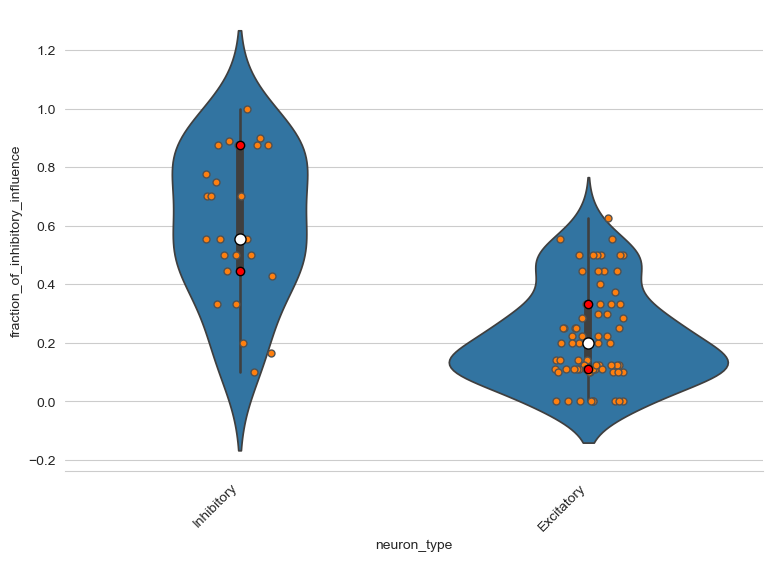

In [473]:
# Change to a bit better style and larger figure.
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(9, 6))

# Plot our violins.
sns.violinplot(x='neuron_type', y='fraction_of_inhibitory_influence', data=df_frac_inh_inf)

sns.stripplot(x='neuron_type', y='fraction_of_inhibitory_influence', data=df_frac_inh_inf,
              jitter=True, linewidth=1)

medians = df_frac_inh_inf.groupby('neuron_type').median().reset_index()
q25 = df_frac_inh_inf.groupby('neuron_type').quantile(0.25).reset_index()
q75 = df_frac_inh_inf.groupby('neuron_type').quantile(0.75).reset_index()

sns.swarmplot(x='neuron_type', y='fraction_of_inhibitory_influence', data=medians,
              color='white', edgecolor='black', linewidth=1, size=8)

sns.swarmplot(x='neuron_type', y='fraction_of_inhibitory_influence', data=q25,
              color='red', edgecolor='black', linewidth=1, size=6)

sns.swarmplot(x='neuron_type', y='fraction_of_inhibitory_influence', data=q75,
              color='red', edgecolor='black', linewidth=1, size=6)


# Rotate the x-axis labels and remove the plot border on the left.
_ = plt.xticks(rotation=45, ha='right')
sns.despine(left=True)

There is a significant difference between the inhibitory and ecitatory neurons in terms of fraction of inhibitory (out of the top ten influencers) neurons that shape their activity. From the distribution of values and the median values we can also hypothesize that the excitatory and inhibitory neurons form a semi-modular architecture with stronger intra-modular and weaker inter-modular interactions. 

In [475]:
# Sample data
group1 = l_inh_frac_fs
group2 = l_inh_frac_ex

# Perform Mann-Whitney U Test
u_stat, p_value = stats.mannwhitneyu(group1, group2)

print(f"U-statistic: {u_stat}, p-value: {p_value}")

U-statistic: 1562.5, p-value: 1.6726261035500303e-08


In [ ]:
l_neuron_type = []
l_inh_inf_frac = []
# l_exc_or_inh = []
# l_sleep_or_wake = []


for ele_fs in l_inh_frac_fs:
    l_neuron_type.append('Inhibitory')
    l_inh_inf_frac.append(ele_fs)

for ele_fs in l_inh_frac_fs_slp:
    l_neuron_type.append('Inhibitory - Sleep')
    l_inh_inf_frac.append(ele_fs)
    
for ele_ex in l_inh_frac_ex:
    l_neuron_type.append('Excitatory')
    l_inh_inf_frac.append(ele_ex)

for ele_ex in l_inh_frac_ex_slp:
    l_neuron_type.append('Excitatory - Sleep')
    l_inh_inf_frac.append(ele_ex)


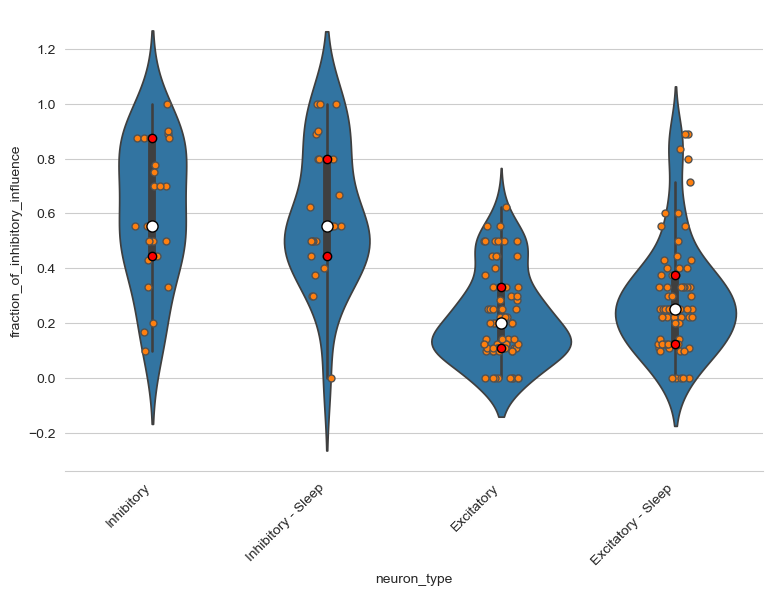

In [459]:
# Change to a bit better style and larger figure.
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(9, 6))

# Plot our violins.
sns.violinplot(x='neuron_type', y='fraction_of_inhibitory_influence', data=df_frac_inh_inf)

sns.stripplot(x='neuron_type', y='fraction_of_inhibitory_influence', data=df_frac_inh_inf,
              jitter=True, linewidth=1)

medians = df_frac_inh_inf.groupby('neuron_type').median().reset_index()
q25 = df_frac_inh_inf.groupby('neuron_type').quantile(0.25).reset_index()
q75 = df_frac_inh_inf.groupby('neuron_type').quantile(0.75).reset_index()

sns.swarmplot(x='neuron_type', y='fraction_of_inhibitory_influence', data=medians,
              color='white', edgecolor='black', linewidth=1, size=8)

sns.swarmplot(x='neuron_type', y='fraction_of_inhibitory_influence', data=q25,
              color='red', edgecolor='black', linewidth=1, size=6)

sns.swarmplot(x='neuron_type', y='fraction_of_inhibitory_influence', data=q75,
              color='red', edgecolor='black', linewidth=1, size=6)


# Rotate the x-axis labels and remove the plot border on the left.
_ = plt.xticks(rotation=45, ha='right')
sns.despine(left=True)

There is no statistically significant difference between the inhibitory neurons between awake and sleep epochs in terms of fraction of inhibitory (out of the top ten influencers) neurons that shape their activity

In [ ]:


# Sample data
group1 = l_inh_frac_fs
group2 = l_inh_frac_fs_slp

# Perform Mann-Whitney U Test
u_stat, p_value = stats.mannwhitneyu(group1, group2)

print(f"U-statistic: {u_stat}, p-value: {p_value}")


U-statistic: 319.5, p-value: 0.8992645084000047


On the other hand, there is a statistically significant difference between the excitatory neurons between awake and sleep epochs in terms of fraction of inhibitory (out of the top ten influencers) neurons that shape their activity

In [462]:
# Sample data
group1 = l_inh_frac_ex
group2 = l_inh_frac_ex_slp

# Perform Mann-Whitney U Test
u_stat, p_value = stats.mannwhitneyu(group1, group2)

print(f"U-statistic: {u_stat}, p-value: {p_value}")

U-statistic: 1980.0, p-value: 0.027146584809893612


In [480]:
l_cellids

[np.uint8(2),
 np.uint8(3),
 np.uint8(4),
 np.uint8(5),
 np.uint8(6),
 np.uint8(7),
 np.uint8(8),
 np.uint8(9),
 np.uint8(10),
 np.uint8(11),
 np.uint8(12),
 np.uint8(13),
 np.uint8(14),
 np.uint8(15),
 np.uint8(16),
 np.uint8(17),
 np.uint8(18),
 np.uint8(19),
 np.uint8(20),
 np.uint8(21),
 np.uint8(22),
 np.uint8(23),
 np.uint8(24),
 np.uint8(25),
 np.uint8(26),
 np.uint8(27),
 np.uint8(28),
 np.uint8(29),
 np.uint8(30),
 np.uint8(31),
 np.uint8(32),
 np.uint8(33),
 np.uint8(34),
 np.uint8(35),
 np.uint8(36),
 np.uint8(37),
 np.uint8(38),
 np.uint8(39),
 np.uint8(40),
 np.uint8(41),
 np.uint8(42),
 np.uint8(43),
 np.uint8(44),
 np.uint8(45),
 np.uint8(46),
 np.uint8(47),
 np.uint8(48),
 np.uint8(49),
 np.uint8(50),
 np.uint8(51),
 np.uint8(52),
 np.uint8(53),
 np.uint8(54),
 np.uint8(55),
 np.uint8(56),
 np.uint8(57),
 np.uint8(58),
 np.uint8(59),
 np.uint8(60),
 np.uint8(61),
 np.uint8(62),
 np.uint8(63),
 np.uint8(64),
 np.uint8(65),
 np.uint8(66),
 np.uint8(67),
 np.uint8(68),
 np

In [497]:
len(l_inh_frac_fs)+len(l_inh_frac_ex), sum(CellTypesData['fs']) + sum(CellTypesData['ex'])

(96, np.uint8(96))

In [493]:
sum(count_ep1.columns == tuning_curve_wake.columns), len(l_cellids)

(np.int64(117), 117)

In [529]:
indices_fs = np.where(CellTypesData['fs'] == 1)
indices_ex = np.where(CellTypesData['ex'] == 1)

In [530]:
l_ind_inh_neurons = []
# indices_fs[0].tolist()
for ind_ in indices_fs[0]:
    l_ind_inh_neurons.append(l_cellids[ind_])

l_ind_ex_neurons = []
for ind_ in indices_ex[0]:
    l_ind_ex_neurons.append(l_cellids[ind_])


In [531]:
permutation_ind_fs = np.argsort(l_inh_frac_fs)
permutation_ind_ex = np.argsort(l_inh_frac_ex)

In [541]:
ex_ind_to_plot = np.asarray(l_ind_ex_neurons)[permutation_ind_ex][1:]
inh_ind_to_plot = np.asarray(l_ind_inh_neurons)[permutation_ind_fs]

In [542]:
len(ex_ind_to_plot), len(inh_ind_to_plot)

(70, 25)

array([57, 67,  2, 33,  5, 54,  7, 24, 10, 51, 58, 20, 38, 29, 16, 37, 19,
       28, 47,  9, 59, 62, 65, 46, 64,  0, 35, 11, 14, 22,  1, 26, 21, 36,
        4, 44, 43, 70, 31, 39, 56, 60, 45, 42, 41, 34, 13, 50, 25, 18, 61,
       49, 69, 17, 32, 12,  3, 63, 66, 27, 55,  8, 53,  6, 52, 15, 68, 48,
       40, 30, 23])

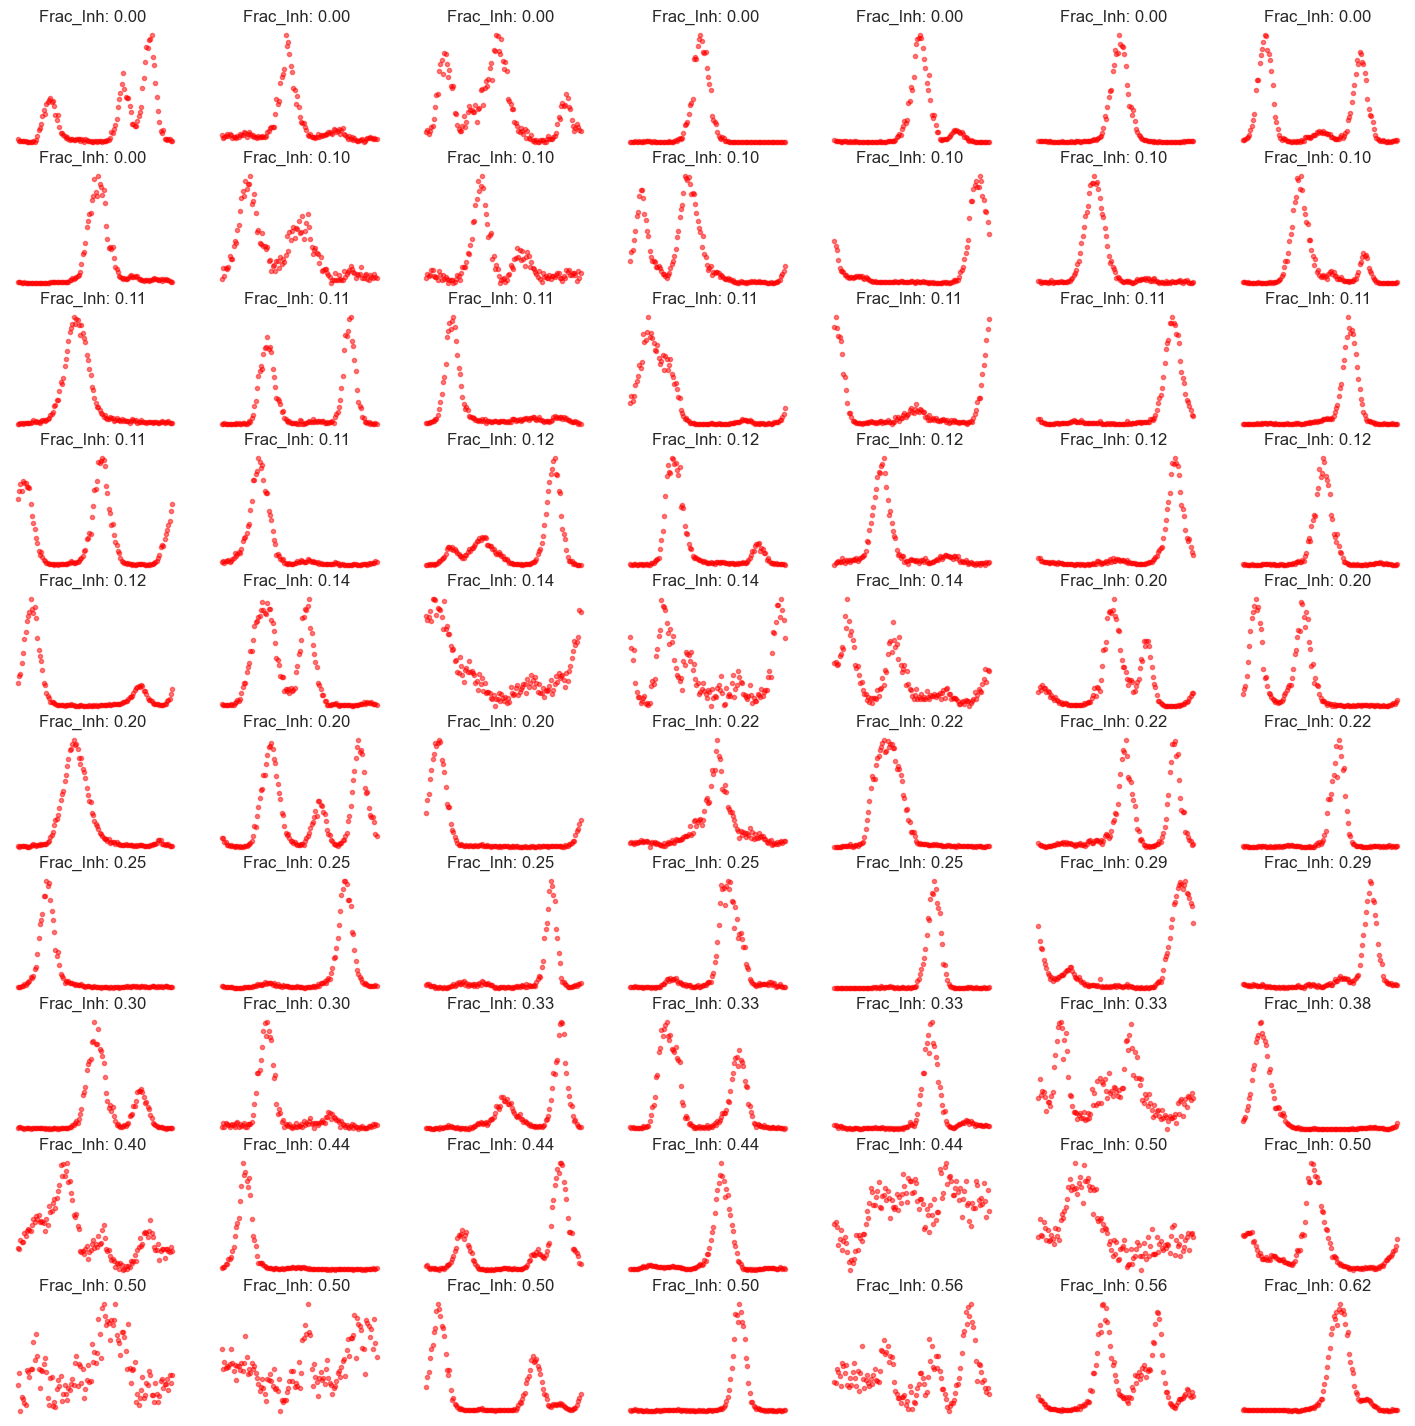

In [553]:
fig, axes = plt.subplots(10,7, figsize=(18,18), subplot_kw={'facecolor':'#ebf5ff'})

in_tune = 0
for i_ax in range(10):
    for j_ax in range(7):
        axes[i_ax, j_ax].scatter(tuning_curve_wake[ex_ind_to_plot[in_tune]].axes[0].tolist(), tuning_curve_wake[ex_ind_to_plot[in_tune]].tolist(), c='r', marker='.', plotnonfinite=True, alpha=0.5)
        
        # axes[i_ax, j_ax].scatter(tuning_curve_sleep[in_tune].axes[0].tolist(), tuning_curve_sleep[in_tune].tolist(), c='k', marker='.', plotnonfinite=True, alpha=0.5)
        
        
        ind_ = permutation_ind_ex[1:][in_tune]
        value = l_inh_frac_ex[ind_]
        
        axes[i_ax, j_ax].set_title("Frac_Inh: {:.2f} ".format(value) )
        axes[i_ax, j_ax].set_axis_off()
        
        in_tune += 1


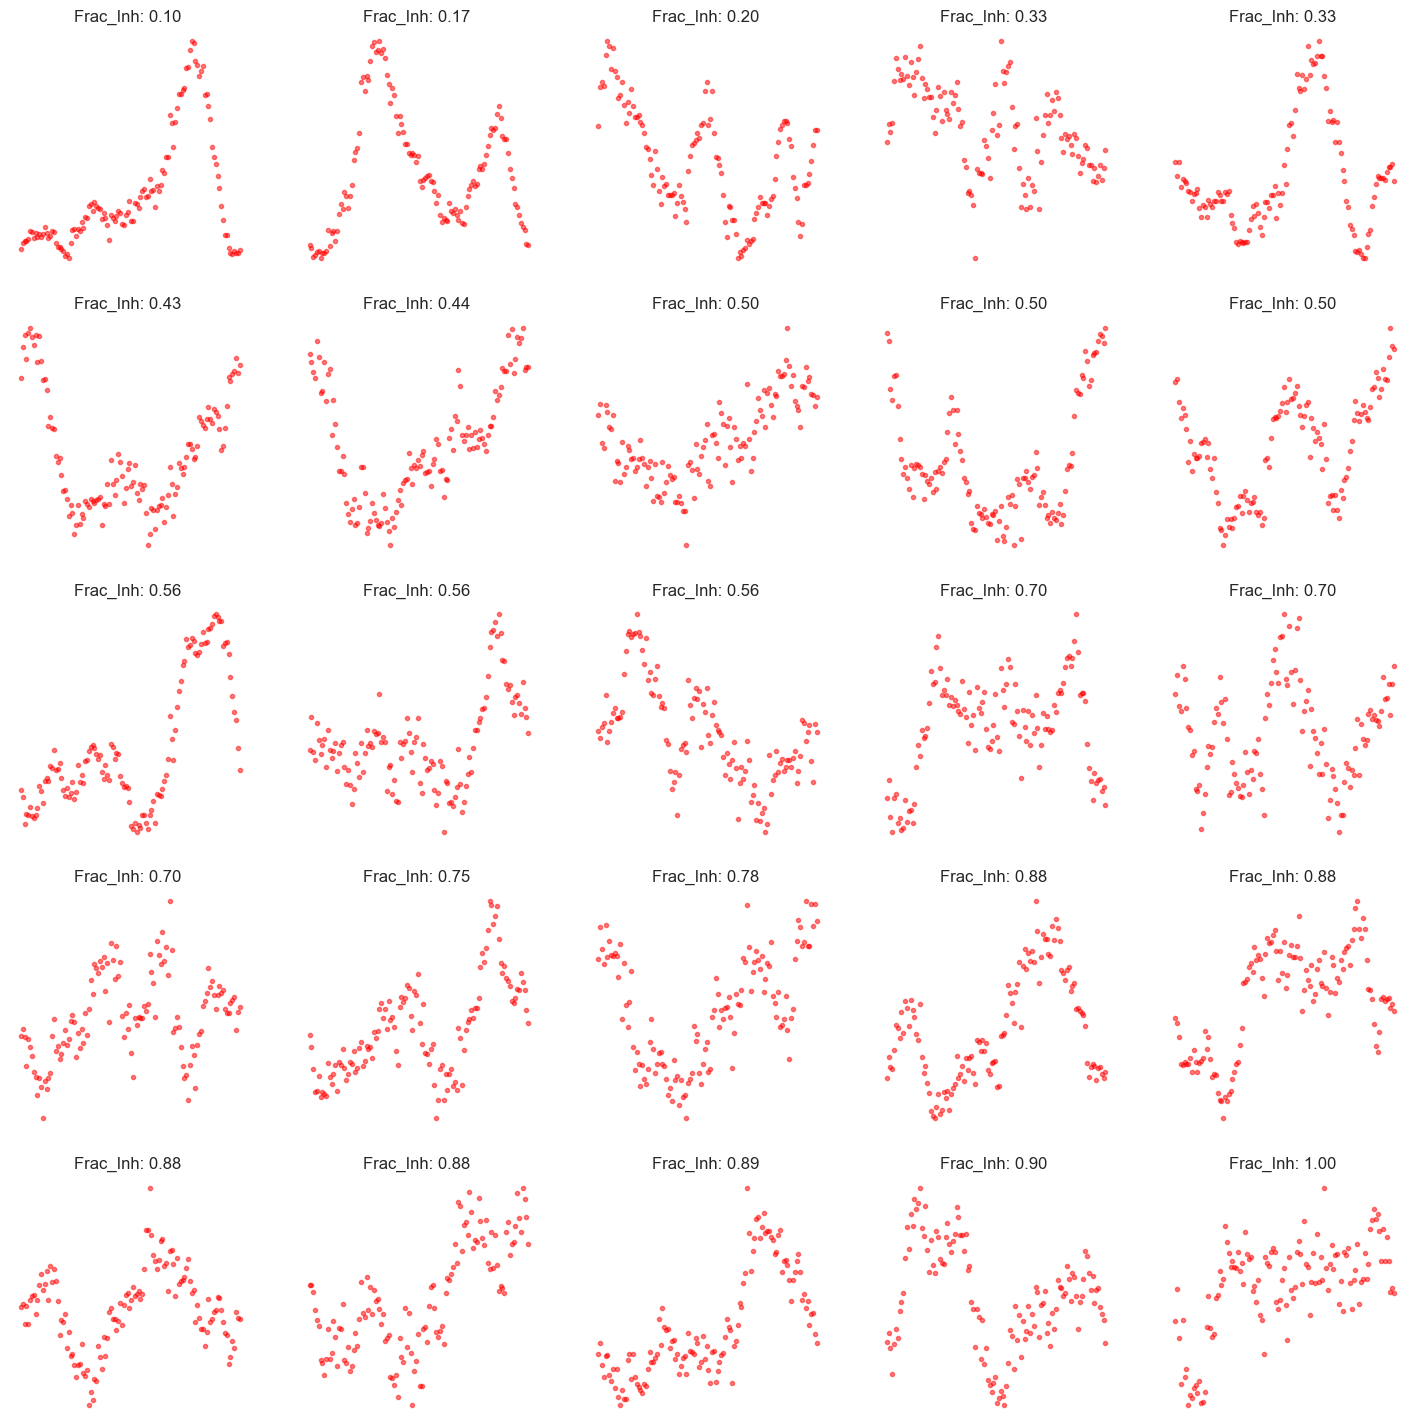

In [554]:
fig, axes = plt.subplots(5,5, figsize=(18,18), subplot_kw={'facecolor':'#ebf5ff'})

in_tune = 0
for i_ax in range(5):
    for j_ax in range(5):
        axes[i_ax, j_ax].scatter(tuning_curve_wake[inh_ind_to_plot[in_tune]].axes[0].tolist(), tuning_curve_wake[inh_ind_to_plot[in_tune]].tolist(), c='r', marker='.', plotnonfinite=True, alpha=0.5)
        # axes[i_ax, j_ax].scatter(tuning_curve_sleep[in_tune].axes[0].tolist(), tuning_curve_sleep[in_tune].tolist(), c='k', marker='.', plotnonfinite=True, alpha=0.5)

        ind_ = permutation_ind_fs[in_tune]
        value = l_inh_frac_fs[ind_]
        
        axes[i_ax, j_ax].set_title("Frac_Inh: {:.2f} ".format(value) )
        axes[i_ax, j_ax].set_axis_off()
        
        in_tune += 1

###  Let's do some decoding now

TODO